In [304]:
import pandas as pd
import numpy as np
import seaborn as sb
from scipy.signal import wiener
import matplotlib.pyplot as plt
import re

from bokeh.io import output_notebook, show
from bokeh.charts import Scatter, Line

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_distances

regex = re.compile('[^a-zA-Z ]')

def remove_duplicate_dates(df, value_text):
    cur_date = None
    vals = []
    dates = []
    for index, row in df.iterrows():
        if row['Date'] != cur_date:
            vals.append(row[value_text])
            dates.append(row['Date'])
            cur_date = row['Date']
    return pd.Series(vals), dates

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx + 1))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

def get_top_words(model, feature_names, n_top_words):
    top_words = []
    for topic_idx, topic in enumerate(model.components_):
        top_words.extend([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    return top_words

def join_text_on_date(df):
    dates = [None]
    titles = []
    bodies = []
    fmp = []
    fmd = []
    for index, row in df.iterrows():
        if row['Date'] == dates[-1]:
            titles[-1] = titles[-1] + row['Title']
            bodies[-1] = bodies[-1] + row['Body']
        else:
            dates.append(row['Date'])
            fmp.append(row['Filtered Mean Proportion'])
            fmd.append(row['Filtered Mean Delta'])
            titles.append(row['Title'])
            bodies.append(row['Body'])
    return pd.DataFrame({'Date': dates[1:], 'Title': titles, 'Body': bodies, 
                         'Filtered Mean Proportion': fmp, 'Filtered Mean Delta': fmd})

In [305]:
output_notebook()

Loading BokehJS ...

In [316]:
df = pd.read_csv('data/dataset-trump.csv') # plug in Obama's stuff here, maybe even merge dfs
df['Title'] = df['Title'].apply(lambda s: s + ' ')
df['Body'] = df['Body'].apply(lambda post: regex.sub('', post).lower())
df['Body'] = df['Body'].apply(lambda s: s + ' ')

In [317]:
nasdaq_values = df[['Date','Nasdaq Value']]
sp_values = df[['Date','S&P 500 Value']]
dowjones_values = df[['Date','Dow Jones Value']]
nasdaq_values, dates = remove_duplicate_dates(nasdaq_values, 'Nasdaq Value')
sp_values, dates = remove_duplicate_dates(sp_values, 'S&P 500 Value')
dowjones_values, dates = remove_duplicate_dates(dowjones_values, 'Dow Jones Value')
mean_values = (nasdaq_values + dowjones_values + sp_values)/3
# sb.tsplot(nasdaq_values)
# sb.tsplot(dowjones_values)
# sb.tsplot(sp_values)
sb.tsplot(mean_values)
plt.title('Average Market Value over Time')
plt.xlabel('Timestep')
plt.ylabel('Value')
plt.show()

UnboundLocalError: local variable 'x' referenced before assignment

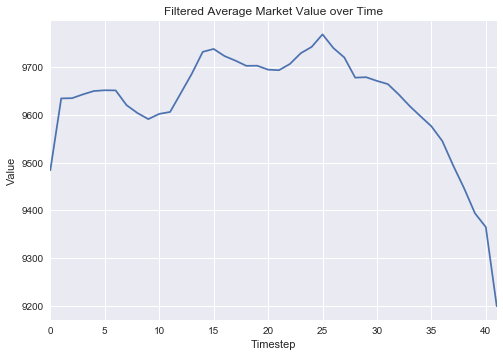

,Date,Title,Body,Nasdaq Value,Nasdaq Delta,Nasdaq Proportion,S&P 500 Value,S&P 500 Delta,S&P 500 Proportion,Dow Jones Value,Dow Jones Delta,Dow Jones Proportion,Filtered Mean Value,Filtered Mean Delta,Filtered Mean Proportion
7,2017-04-05,Readout of President Donald J. Trump’s Call wi...,president donald j trump spoke today with prim...,5864.479980,14.470215,0.002467,2352.949951,4.540039,0.001930,20648.150391,14.798828,0.000717,9634.775526,-150.463408,-0.001705
8,2017-04-05,Statement from the Press Secretary on Gold Sta...,on this day in nearing the end of world war i...,5864.479980,14.470215,0.002467,2352.949951,4.540039,0.001930,20648.150391,14.798828,0.000717,9634.775526,-150.463408,-0.001705
9,2017-04-05,Memorandum: Implementing Executive Order 13771...,mmemorandum forregulatory policy officers at e...,5864.479980,14.470215,0.002467,2352.949951,4.540039,0.001930,20648.150391,14.798828,0.000717,9634.775526,-150.463408,-0.001705
10,2017-04-05,Readout of President Donald J. Trump’s Call wi...,president donald j trump spoke today by teleph...,5864.479980,14.470215,0.002467,2352.949951,4.540039,0.001930,20648.150391,14.798828,0.000717,9634.775526,-150.463408,-0.001705
11,2017-04-05,A Proclamation by President Donald J. Trump Ho...,honoring the memory of john glenn by the ...,5864.479980,14.470215,0.002467,2352.949951,4.540039,0.001930,20648.150391,14.798828,0.000717,9634.775526,-150.463408,-0.001705
12,2017-04-05,Statement from the Press Secretary on the Decl...,statement from the press secretarytodays annou...,5864.479980,14.470215,0.002467,2352.949951,4.540039,0.001930,20648.150391,14.798828,0.000717,9634.775526,-150.463408,-0.001705
13,2017-04-05,Remarks by President Trump and His Majesty Kin...,rose garden pm edtpresident trump thank you ve...,5864.479980,14.470215,0.002467,2352.949951,4.540039,0.001930,20648.150391,14.798828,0.000717,9634.775526,-150.463408,-0.001705
14,2017-04-05,Readout of First Lady Melania Trump’s Visit to...,after a brief visit to the oval office with th...,5864.479980,14.470215,0.002467,2352.949951,4.540039,0.001930,20648.150391,14.798828,0.000717,9634.775526,-150.463408,-0.001705
15,2017-04-05,Press Briefing on the Congressional Review Act,james s brady press briefing room am edtmr spi...,5864.479980,14.470215,0.002467,2352.949951,4.540039,0.001930,20648.150391,14.798828,0.000717,9634.775526,-150.463408,-0.001705
16,2017-04-05,1600 Daily: Everything White House for 4/5/17,summaryget news events and updates from the wh...,5864.479980,14.470215,0.002467,2352.949951,4.540039,0.001930,20648.150391,14.798828,0.000717,9634.775526,-150.463408,-0.001705


In [292]:
# Filter Values and Reassign
# Filter after averaging
filtered_mean_values = wiener(mean_values, noise=None)
mean_values_df = pd.DataFrame({'Filtered Mean Value': filtered_mean_values, 'Date': dates})
mean_values_df['Filtered Mean Delta'] = -mean_values_df['Filtered Mean Value'].diff(periods=1)
nasdaq_delta = nasdaq_values.diff(periods=1)
sp_delta = sp_values.diff(periods=1)
dowjones_delta = dowjones_values.diff(periods=1)
mean_values_df['Filtered Mean Proportion'] =  (nasdaq_delta/nasdaq_values + sp_delta/sp_values 
                                               + dowjones_delta/dowjones_values)/3

df = pd.merge(df, mean_values_df, on='Date', how='left').dropna()
sb.tsplot(filtered_mean_values)
plt.title('Filtered Average Market Value over Time')
plt.xlabel('Timestep')
plt.ylabel('Value')
plt.show()
df

In [293]:
# Vectorize Blog Posts with BOW 
initial_vectorizer = CountVectorizer(stop_words='english', min_df=0.05, max_df=0.8)
data = initial_vectorizer.fit_transform(df['Body'])

In [294]:
distances = cosine_distances(data)
mds = MDS(n_components=2, dissimilarity='precomputed')
pos = mds.fit_transform(distances)

In [295]:
lda = LatentDirichletAllocation(n_topics=5, random_state=42, learning_method='online')
topic_scores = lda.fit_transform(data)
labels = np.argmax(topic_scores, axis=1)

In [296]:
print_top_words(lda, initial_vectorizer.get_feature_names(), 20)


Topic #1:
united states order law federal executive security trump regulatory agency department agencies secretary shall state general national actions mr court

Topic #2:
trump house official white administration american donald coal jobs new signed energy office trumps march regulations speech senior clean address

Topic #3:
health obamacare healthcare insurance american care americans trump people plan vice price congress coverage year families house costs states small

Topic #4:
think spicer going thats just people im said dont know house theres question mr administration hes want look white make

Topic #5:
going thank people great know just want im country thats american good states applause think jobs right like united really



In [297]:
lda_df = {'x':pos[:, 0], 'y':pos[:,1], 'label':labels}
show(Scatter(lda_df, x='x', y='y', color='label', title='LDA Clusters - Trump'))

In [298]:
# Topic Stats
df['Topic Label'] = labels
grouped = df.groupby('Topic Label')
print('Delta Stats')
print(grouped['Filtered Mean Delta'].mean())
print(grouped['Filtered Mean Delta'].std())
print()
print('Proportion Stats')
print(grouped['Filtered Mean Proportion'].mean())
print(grouped['Filtered Mean Proportion'].std())
print(grouped['Filtered Mean Proportion'].count())

Delta Stats
Topic Label
0     7.330117
1    -1.231513
2    -0.716205
3     1.873197
4    10.032429
Name: Filtered Mean Delta, dtype: float64
Topic Label
0    45.167033
1    38.446231
2    38.008700
3    31.370813
4    32.958971
Name: Filtered Mean Delta, dtype: float64

Proportion Stats
Topic Label
0   -0.001606
1   -0.001005
2    0.000080
3   -0.000449
4   -0.001472
Name: Filtered Mean Proportion, dtype: float64
Topic Label
0    0.004951
1    0.004002
2    0.003972
3    0.004264
4    0.004925
Name: Filtered Mean Proportion, dtype: float64
Topic Label
0    178
1     87
2     52
3     43
4     96
Name: Filtered Mean Proportion, dtype: int64


In [284]:
df[df['Topic Label'].apply(lambda x: True if x in (0,1,4) else False)].groupby('Date')['Title'].sum()

Date
2017-02-07    Readout of the President's Call with Prime Min...
2017-02-08    Statement from the Press Secretary First Lady ...
2017-02-09    Readout of the President’s Call with President...
2017-02-10    President Trump’s Weekly Address Readout of th...
2017-02-13    President Donald J. Trump Names Lt. General Jo...
2017-02-14    President Trump Approves Disaster Declaration ...
2017-02-15    Joint Readout of Meeting Between President Don...
2017-02-16    Readout of the President's Call with President...
2017-02-17    President Trump Approves Nevada Disaster Decla...
2017-02-21    Readout of the Vice President's Meeting with A...
2017-02-22    Remarks by the Vice President to Fabick Cat Em...
2017-02-23    Remarks by President Trump at Listening Sessio...
2017-02-24    Readout of the President's Meeting with Presid...
2017-02-27    President Donald J. Trump and First Lady Melan...
2017-02-28    Remarks by President Trump in Joint Address to...
2017-03-02    Editorials Praise Pre

In [300]:
# Revectorize Blog Posts to Label each post with a topic
topic_vectorizer = CountVectorizer(vocabulary=set(get_top_words(lda, initial_vectorizer.get_feature_names(), 50)))
data = topic_vectorizer.transform(df['Body'])
distance = cosine_distances(data)
pos = mds.fit_transform(distance)

In [301]:
topic_df = pd.DataFrame({'x':pos[:,0], 'y':pos[:,1], 'label':df['Topic Label']})
show(Scatter(topic_df, x='x', y='y', color='label', title='Topic Feature Space Clusters - Trump'))

In [ ]:
# Add Decision Tree Here
# Create Positive Example Set and Negative Example Set

In [287]:
# If so, filter the blog posts based on topic first
data_df = df[df['Topic Label'].apply(lambda x: True if x in (0,1,4) else False)][['Date', 'Title', 'Body', 'Filtered Mean Proportion', 'Filtered Mean Delta']]
data_df

,Date,Title,Body,Filtered Mean Proportion,Filtered Mean Delta
7,2017-04-05,Readout of President Donald J. Trump’s Call wi...,president donald j trump spoke today with prim...,-0.001705,-150.463408
9,2017-04-05,Memorandum: Implementing Executive Order 13771...,mmemorandum forregulatory policy officers at e...,-0.001705,-150.463408
10,2017-04-05,Readout of President Donald J. Trump’s Call wi...,president donald j trump spoke today by teleph...,-0.001705,-150.463408
11,2017-04-05,A Proclamation by President Donald J. Trump Ho...,honoring the memory of john glenn by the ...,-0.001705,-150.463408
12,2017-04-05,Statement from the Press Secretary on the Decl...,statement from the press secretarytodays annou...,-0.001705,-150.463408
13,2017-04-05,Remarks by President Trump and His Majesty Kin...,rose garden pm edtpresident trump thank you ve...,-0.001705,-150.463408
14,2017-04-05,Readout of First Lady Melania Trump’s Visit to...,after a brief visit to the oval office with th...,-0.001705,-150.463408
16,2017-04-05,1600 Daily: Everything White House for 4/5/17,summaryget news events and updates from the wh...,-0.001705,-150.463408
17,2017-04-05,First Lady Melania Trump to Host Queen Rania o...,first lady melania trump along with her husban...,-0.001705,-150.463408
18,2017-04-05,"Photo of the Day: April 5, 2017",president donald trump responds to a question ...,-0.001705,-150.463408


In [288]:
# Join the blog posts that are on the same day
joined_data_df = join_text_on_date(data_df)[['Date', 'Title', 'Body', 'Filtered Mean Delta', 'Filtered Mean Proportion']]
joined_data_df

,Date,Title,Body,Filtered Mean Delta,Filtered Mean Proportion
0,2017-04-05,Readout of President Donald J. Trump’s Call wi...,president donald j trump spoke today with prim...,-150.463408,-0.001705
1,2017-04-04,Two Nominations Delivered to the Senate Today ...,nominations sent to the senatesigal mandelker ...,-0.482422,0.003609
2,2017-04-03,Readout of President Donald J. Trump’s Meeting...,president donald j trump today welcomed presid...,-8.011176,-0.001039
3,2017-03-31,Presidential Executive Order on Establishing E...,executive order establishing enhanced col...,-6.986681,0.001719
4,2017-03-30,Joint Readout of Meeting Between President Don...,the president today welcomed prime minister la...,-1.585422,0.001948
5,2017-03-29,Notice Regarding the Continuation of the Natio...,notice continuation of the national emerg...,0.274523,-0.003043
6,2017-03-28,President Donald J. Trump Signs S. 305 into La...,on tuesday march the president signed into l...,30.883274,-0.000954
7,2017-03-27,Background Briefing on the President's Energy ...,james s brady press briefing room pm edtsenior...,16.506565,-0.006843
8,2017-03-24,President Trump Delivers on Jobs for the Ameri...,today we take one more step in putting the job...,12.775581,0.000415
9,2017-03-23,Joint Readout United States-Israeli Consultati...,seniorlevel united states and israeli delegati...,-10.938911,0.000614


In [ ]:
# Vectorize them using BOW
# Can possibly try a word embeddings model to featurize our blogs

In [ ]:
# Create an Autoencoder to reduce dimensionality. Talk about how to tune one.

In [ ]:
# Create a testing set now, we may not have enough data...
# Worse come to worse, we can use Obama's posts to train on and predict Trump's posts
# I would have to redo the above analysis though... which is fine

In [ ]:
# Train a logistic regression model, qda model, random forest, and neural network model

In [ ]:
# If needed, train an LSTM... 

In [ ]:
# Submit the data and notebook to Professor Nelson